In [1]:

import numpy as np
import blip_analysis as ba
import matplotlib.pyplot as plt
import pickle
import scipy
from tqdm import trange
from matplotlib.gridspec import GridSpec
from label_axes import label_axes
from scipy.optimize import minimize

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

b


In [2]:
## Load data
unit_usrt1, unit_usrt2, unit_usrt3 = ba.load_usrts()
good_indexes = ba.get_stable_resp_indexes()
glyphs = ba.get_glyphs()

Found odour 1
Found odour 3
Found odour 5


In [3]:
### Run to load in all the models
diff_models1 = pickle.Unpickler(open('../Data/230320_diff_models1.pkl', 'rb')).load()
diff_models2 = pickle.Unpickler(open('../Data/230320_diff_models2.pkl', 'rb')).load()
diff_models3 = pickle.Unpickler(open('../Data/230320_diff_models3.pkl', 'rb')).load()
model_length = 130

In [4]:
### Loading responsive cells from the 230509_fig5_2PCs.ipynb - only cells which are 'responsive' to all three odours
responsive_only_cells = np.load('../Data/230515_all_responsive_cells.npy')
diff_models1 = diff_models1[responsive_only_cells]
diff_models2 = diff_models2[responsive_only_cells]
diff_models3 = diff_models3[responsive_only_cells]
model_length = 66

In [5]:
### Fit all models to ensure their weighting has all repeats
[i.fit() for i in diff_models1];
[i.fit() for i in diff_models2];
[i.fit() for i in diff_models3];

In [6]:
## calculate the mean and std of each cell
mean_usrt1 = [[np.mean(np.mean(i, axis=-1)) for i in j] for j in unit_usrt1[good_indexes][responsive_only_cells]]
std_usrt1 = [[np.std(np.mean(i, axis=-1)) for i in j] for j in unit_usrt1[good_indexes][responsive_only_cells]]
mean_usrt2 = [[np.mean(np.mean(i, axis=-1)) for i in j] for j in unit_usrt2[good_indexes][responsive_only_cells]]
std_usrt2 = [[np.std(np.mean(i, axis=-1)) for i in j] for j in unit_usrt2[good_indexes][responsive_only_cells]]
mean_usrt3 = [[np.mean(np.mean(i, axis=-1)) for i in j] for j in unit_usrt3[good_indexes][responsive_only_cells]]
std_usrt3 = [[np.std(np.mean(i, axis=-1)) for i in j] for j in unit_usrt3[good_indexes][responsive_only_cells]]
corrs13 = [np.corrcoef(i, j)[0, 1] for i, j in zip(mean_usrt1, mean_usrt3)]
corr_args13 = np.argsort(np.abs(corrs13))
corrs23 = [np.corrcoef(i, j)[0, 1] for i, j in zip(mean_usrt2, mean_usrt3)]
corr_args23 = np.argsort(np.abs(corrs23))

In [7]:
### Load in the other odour fit results (this takes the 66 responsive cells)
res = np.load('../Data/230704_other_odour_fits.npy', allow_pickle=True)

In [8]:
## reshaping
cell_preds12 = res[0, 0, :, 0, :]
scores12 = res[0, 0, :, 1, :]
cell_preds13 = res[0, 1, :, 0, :]
scores13 = res[0, 1, :, 1, :]
cell_preds21 = res[1, 0, :, 0, :]
scores21 = res[1, 0, :, 1, :]
cell_preds23 = res[1, 1, :, 0, :]
scores23 = res[1, 1, :, 1, :]
cell_preds31 = res[2, 0, :, 0, :]
scores31 = res[2, 0, :, 1, :]
cell_preds32 = res[2, 1, :, 0, :]
scores32 = res[2, 1, :, 1, :]

In [9]:
def plot_score_fracs(scores1, scores2, odour1_label='Odour 1', odour2_label='Odour 2', ax=None, colors=['C0', 'C1', 'r'], show_best=True):
    '''Plots the fraction of cells which are fit better to another odour response than a given cell - generates part A'''
    scores_frac1 = []
    scores_frac2 = []
    for i in range(model_length):
        self_score1 = scores1[i][i]
        self_score2 = scores2[i][i]
        scores_frac1.append(len(np.where(np.array(scores1)[i] < self_score1)[0])/model_length)
        scores_frac2.append(len(np.where(np.array(scores2)[i] < self_score2)[0])/model_length)
    min_score_fracs = np.min([scores_frac1, scores_frac2], axis=0)
    best_odour_fracs = np.array([scores_frac1, scores_frac2]).argmin(axis=0)

    frac_args1 = np.argsort(scores_frac1)
    frac_args2 = np.argsort(scores_frac2)
    minfracs_args = np.argsort(min_score_fracs)

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.plot(np.array(scores_frac1)[frac_args1], label=odour1_label, color=colors[0])
    ax.plot(np.array(scores_frac2)[frac_args2], label=odour2_label, color=colors[1])
    if show_best:
        ax.plot(np.array(min_score_fracs)[minfracs_args], label='Min of both odours', color=colors[2])
    ax.axhline(0.5, color='k', linestyle='--')
    ax.set_xlabel('Sorted cell number')
    ax.set_ylabel('Fraction of cells with better fit')
    ax.axvline(int(model_length/2), color='k', linestyle='--')

    print(len(np.where(np.array(scores_frac1) < 0.5)[0]))
    print(len(np.where(np.array(scores_frac2) < 0.5)[0]))
    print(len(np.where(np.array(min_score_fracs) < 0.5)[0]))
    fracs = [len(np.where(np.array(scores_frac1) < 0.5)[0]), len(np.where(np.array(scores_frac2) < 0.5)[0]), len(np.where(np.array(min_score_fracs) < 0.5)[0])]
    joint_args = [frac_args1, frac_args2, minfracs_args]
    return ax, fracs, joint_args



def auto_scale(odour1, odour2, ui):
    '''Automatically scales the two odour responses to minimise the sum of squared differences'''
    data1 = np.array(odour1[ui])
    data2 = np.array(odour2[ui])

    x_data = np.array(range(32))
    init_limits = [0, 100]

    result = minimize(calc_diff, init_limits, args=(data1, data2), method='Nelder-Mead', tol=1e-20, options={'maxiter': 10000})
    return result.x

def calc_diff(limits, data1, data2):
    '''Calculates the sum of squared differences between two odour responses, scaled to the limits given'''
    lower, upper = limits
    
    # Rescale data
    scaled_data2 = lower + (data2 - np.min(data2))*(upper - lower) / (np.max(data2) - np.min(data2))
    
    # Calculate sum of squared differences
    diff = np.sum((data1 - scaled_data2)**2)
    return diff




def plot_multi_odour_response2(cell_index, odour1, odour2, ax=None, odour1_std = None, odour2_std = None, legend=False, remove_spine_top=False):
    '''Plots the responses of a given cell to two odours, scaled to minimise the sum of squared differences'''
    data1 = np.array(odour1[cell_index])
    data2 = np.array(odour2[cell_index])
    lower, upper = auto_scale(odour1, odour2, cell_index)
    scaled_data2 = lower + (data2 - np.min(data2))*(upper - lower) / (np.max(data2) - np.min(data2))
    scaled_err = np.abs((upper - lower) / (np.max(data2) - np.min(data2)) * np.array(odour2_std[cell_index]))

    print(min(scaled_err), max(scaled_err))
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.errorbar(np.arange(0, 64, 2), data1, yerr=odour1_std[cell_index], fmt='.', color='k', linewidth=1)
    ax.errorbar(np.arange(0.5, 64.5, 2), scaled_data2, yerr=scaled_err,  fmt='.', color='r', linewidth=1)
    ax.set_xticks(np.arange(0.25, 64.25, 2))
    ax.set_xticklabels(glyphs, rotation=90);
    ylims = ax.get_ylim()
    ax2 = ax.twinx()
    scaled_ylims = ((np.array(ylims) - lower) * (np.max(data2) - np.min(data2)) / (upper - lower)) + np.min(data2)
    ax2.set_ylim(scaled_ylims)
    ax2.set_ylabel('Firing rate O2 (Hz)', color='r')
    ax2.tick_params(axis='y', colors='red')
    ax2.spines['right'].set_color('red')
    ax.set_ylabel('Firing rate O1 (Hz)')
    if remove_spine_top:
        ax.spines['top'].set_visible(False)
        ax2.spines['top'].set_visible(False)


In [10]:



def plot_significance(ax, x_pos, sig_level, y_level, rotation=False):
    if rotation:
        ax.plot([y_level, y_level], [x_pos[0], x_pos[1]], color='k')
        ax.text(y_level*1.01, np.mean(x_pos), sig_level, horizontalalignment='left', verticalalignment='center', rotation=90)
    else:
        ax.plot([x_pos[0], x_pos[1]], [y_level, y_level], color='k')
        ax.text(np.mean(x_pos), y_level, sig_level, horizontalalignment='center', verticalalignment='bottom')

# vp = ax.violinplot([corrs, random_corr, np.abs(corrs), np.abs(random_corr)], showmeans=True, positions=x_pos, showextrema=False)
# for pc in vp['bodies']:
#     pc.set_facecolor('lightgrey')
#     pc.set_edgecolor('lightgrey')
#     pc.set_alpha(1)
# vp['cmeans'].set_color('black')
# ax.set_ylabel('Correlation coefficient')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.set_xticks(x_pos)
# ax.set_xticklabels(['O1 O2', 'Shuffle', 'Absolute O1 O2', 'Absolute shuffle'], rotation=90)

# plot_significance(ax, [0, 1], '****', 1.05)
# plot_significance(ax, [3, 4], '****', 1.05)
def plot_violinplot(fig, gs, data, x_pos, rotation=False):
    ax = fig.add_subplot(gs)
    # plotting the violin plots rotated 90 degrees
    vp = ax.violinplot(data, showmeans=True, positions=x_pos, showextrema=False, vert= not rotation)
    for pc in vp['bodies']:
        pc.set_facecolor('lightgrey')
        pc.set_edgecolor('lightgrey')
        pc.set_alpha(1)
    vp['cmeans'].set_color('black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if rotation:
        ax.set_yticks(x_pos)
        ax.set_yticklabels(['O1 O2', 'Shuffle', 'Absolute O1 O2', 'Absolute shuffle'])
        ax.set_xlabel('Correlation coefficient')
    else:
        ax.set_xticks(x_pos)
        ax.set_xticklabels(['O1 O2', 'Shuffle', '|O1 O2|', '|Shuffle|'], rotation=90)
        ax.set_ylabel('Correlation coefficient')
    return ax

# fig = plt.figure()
# gs = fig.add_gridspec(1, 1)
# x_pos = [0, 1, 3, 4]
# ax = plot_violinplot(fig, gs[0], [corrs, random_corr, np.abs(corrs), np.abs(random_corr)], x_pos, rotation=False)
# plot_significance(ax, [0, 1], '****', 1.05, rotation=False)
# plot_significance(ax, [3, 4], '****', 1.05, rotation=False)


In [21]:
better_corrs12 = []
best_corrs12 = []
better_corrs13 = []
best_corrs13 = []
better_corrs23 = []
best_corrs23 = []
for i in range(66):
    base_corr = np.abs(np.corrcoef(mean_usrt1[i], mean_usrt2[i])[0,1])
    other_corrs = [np.abs(np.corrcoef(mean_usrt1[i], mean_usrt2[j])[0,1]) for j in range(66) if j != i]
    if base_corr > np.median(other_corrs):
        better_corrs12.append(i)
    if base_corr > np.max(other_corrs):
        best_corrs12.append(i)

    base_corr = np.abs(np.corrcoef(mean_usrt1[i], mean_usrt3[i])[0,1])
    other_corrs = [np.abs(np.corrcoef(mean_usrt1[i], mean_usrt3[j])[0,1]) for j in range(66) if j != i]
    if base_corr > np.median(other_corrs):
        better_corrs13.append(i)
    if base_corr > np.max(other_corrs):
        best_corrs13.append(i)
    
    base_corr = np.abs(np.corrcoef(mean_usrt2[i], mean_usrt3[i])[0,1])
    other_corrs = [np.abs(np.corrcoef(mean_usrt2[i], mean_usrt3[j])[0,1]) for j in range(66) if j != i]
    if base_corr > np.median(other_corrs):
        better_corrs23.append(i)
    if base_corr > np.max(other_corrs):
        best_corrs23.append(i)


In [19]:
## calculate the mean and std of each cell
mean_usrt1 = [[np.mean(np.mean(i, axis=-1)) for i in j] for j in unit_usrt1[good_indexes][responsive_only_cells]]
std_usrt1 = [[np.std(np.mean(i, axis=-1)) for i in j] for j in unit_usrt1[good_indexes][responsive_only_cells]]
mean_usrt2 = [[np.mean(np.mean(i, axis=-1)) for i in j] for j in unit_usrt2[good_indexes][responsive_only_cells]]
std_usrt2 = [[np.std(np.mean(i, axis=-1)) for i in j] for j in unit_usrt2[good_indexes][responsive_only_cells]]
mean_usrt3 = [[np.mean(np.mean(i, axis=-1)) for i in j] for j in unit_usrt3[good_indexes][responsive_only_cells]]
std_usrt3 = [[np.std(np.mean(i, axis=-1)) for i in j] for j in unit_usrt3[good_indexes][responsive_only_cells]]
corrs = [np.corrcoef(i, j)[0, 1] for i, j in zip(mean_usrt1, mean_usrt2)]
print(np.argsort(np.abs(corrs)))
corr_args = np.argsort(np.abs(corrs))


[ 3 51 41 12  4 24  2 63 31 52 49 53 21 44  6 47 22 25 64 10 43 36 16 13
 11 58 15 60 56 23 20  5 55 54 17 62 48  8 59  0 50  1 57 18 45  9 33 26
 14 35 30 46 29 28 42 38 19 65 61 27  7 40 37 32 39 34]


2.425808265535662 9.58730729276665
1.4318616556306039 5.320862022819265


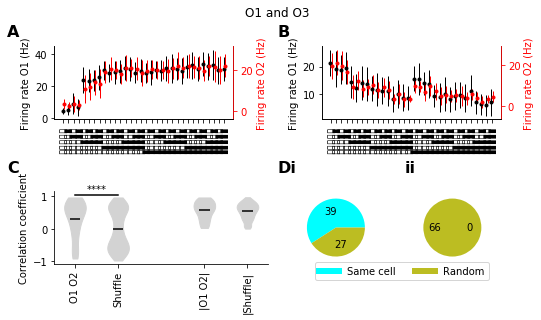

In [36]:
def sig_label(p_val):
    stat = ''
    if p_val < 0.05:
        stat += '*'
    if p_val < 0.01:
        stat += '*'
    if p_val < 0.001:
        stat += '*'
    if p_val < 0.0001:
        stat += '*'
    return stat

x_pos = [0, 1, 3, 4]

## Set which comparison here mus1 and mus2 are the mean_usrt from the two odours
mus1 = mean_usrt1
mus2 = mean_usrt3
mus_std1 = std_usrt1
mus_std2 = std_usrt3
best_corrs = best_corrs13
better_corrs = better_corrs13
random_corr = [np.corrcoef(mus1[i], mus2[j])[0, 1] for i, j in zip(np.random.choice(np.arange(len(mus1)), size=500, replace=True), np.random.choice(np.arange(len(mus2)), size=500, replace=True))]
corrs = [np.corrcoef(i, j)[0, 1] for i, j in zip(mus1, mus2)]
corr_args = np.argsort(np.abs(corrs))
abs_sig = scipy.stats.ttest_ind(np.abs(corrs), np.abs(random_corr))[1]
sig = scipy.stats.ttest_ind(corrs, random_corr)[1]



fig = plt.figure(figsize=(8, 4))
gs = fig.add_gridspec(2, 4, hspace=1)
resp_gs = gs[0, :].subgridspec(1, 2, wspace=0.5)
best_response_ax1 = fig.add_subplot(resp_gs[0])
best_response_ax2 = fig.add_subplot(resp_gs[1])
plot_multi_odour_response2(corr_args[-1], mus1, mus2, odour1_std=mus_std1, odour2_std=mus_std2, ax=best_response_ax1, remove_spine_top=True)
plot_multi_odour_response2(corr_args[-4], mus1, mus2, odour1_std=mus_std1, odour2_std=mus_std2, ax=best_response_ax2, remove_spine_top=True)
violin_ax = plot_violinplot(fig, gs[1, :2], [corrs, random_corr, np.abs(corrs), np.abs(random_corr)], x_pos, rotation=False)
base_sig_level = sig_label(sig)
abs_sig_level = sig_label(abs_sig)
if sig < 0.05:
    plot_significance(violin_ax, [0, 1], base_sig_level, 1.05)
if abs_sig < 0.05:
    plot_significance(violin_ax, [4, 3], abs_sig_level, 1.05)
pie_gs = gs[1, 2:].subgridspec(1, 2)
pie_ax1 = fig.add_subplot(pie_gs[0])
better_counts = np.array([len(better_corrs), 66-len(better_corrs)])
best_counts = np.array([len(best_corrs), 66-len(best_corrs)])
pie_colors = ['cyan', 'C8']
pie_ax1.pie(better_counts, colors=pie_colors, autopct=lambda x: '{:.0f}'.format(x*better_counts.sum()/100))#, labels=[len(better_corrs), 66-len(better_corrs)])
pie_ax2 = fig.add_subplot(pie_gs[1])
pie_ax2.pie(best_counts, colors=pie_colors, autopct=lambda x: '{:.0f}'.format(x*best_counts.sum()/100))
pie_ax2.plot([], [], pie_colors[0], label='Same cell', linewidth=6)
pie_ax2.plot([], [], pie_colors[1], label='Random', linewidth=6)

axes = [best_response_ax1, best_response_ax2, violin_ax, pie_ax1, pie_ax2]
labels = ['A', 'B', 'C', 'Di', 'ii']
align_x = [[0, 2], [1, 3]]
align_y = [[0, 1], [2, 3, 4]]
dx = [-0.02, -0.02, -0.02, -0.02, -0.02]
label_axes.label_axes(axes, labels, fontsize=16, fontweight='bold', align_x=align_x, align_y=align_y, align_x_fun=np.min, align_y_fun=np.max, dx=dx)
pie_ax2.legend(bbox_to_anchor=(-0.2, -0.1), ncol=2, loc='center')
# pie_ax1.set_title('Better than median')
# pie_ax2.set_title('Better than max')
#plt.savefig('230908_Fig7.pdf', bbox_inches='tight')
title_ax = fig.add_subplot(111, frameon=False)
title_ax.set_xticks([])
title_ax.set_yticks([])
title_ax.set_title('O1 and O3', pad=30)
plt.savefig('230912_Sup72_O1O3.pdf', bbox_inches='tight')